# C1 W2 Group 8

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import pandas as pd

from src.data import GT_QSD1_W2_LIST, GT_QSD2_W2_LIST
from src.paths import BBDD_PATH, WEEK_2_RESULTS_PATH, QSD1_W2_PATH, QSD2_W2_PATH, QST1_W2_PATH, QST2_W2_PATH
from src.descriptors import MultiColorSpaceHistogramDescriptor1D, ColorHistogramDescriptor3D, MultiColorSpaceHistogramDescriptor3D
from src.similarities import HistogramIntersection, HellingerKernel, Bhattacharyya
from src.metrics import MeanAveragePrecisionAtK
from tqdm import tqdm
import datetime
from skimage import filters
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score

## Task 1 & 2 - Implement 3D / 2D and block and hierarchical histograms

### Data processing : Image loading, partitioning & descriptor computation

First, we compute the partitions of the images, and the corresponding descriptors

In [2]:
database_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(BBDD_PATH.glob("*.jpg"))]  # Load once
for idx, db_img in enumerate(database_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.jpg")

In [3]:
query_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD1_W2_PATH.glob("*.jpg"))]  # Load once
for idx, query_img in enumerate(query_image_PIL_list):
    assert query_img.filename.endswith(f"{idx}.jpg")

In [4]:
def partition_image(image: Image.Image, N: int):
    img_width, img_height = image.size
    
    # Compute info about the partition
    rows = cols = int(N)  # Assuming N is a perfect square
    part_width = img_width // cols
    part_height = img_height // rows
    
    partitions = []
    
    # Crop each partition
    for row in range(rows):
        for col in range(cols):
            left = col * part_width
            top = row * part_height
            right = left + part_width
            bottom = top + part_height
            part = image.crop((left, top, right, bottom))
            partitions.append(part)
    
    return partitions

def plot_partitions(image, N):
    img_width, img_height = image.size
    
    # Compute info about the partition
    rows = cols = int(N)  # Assuming N is a perfect square
    part_width = img_width // cols
    part_height = img_height // rows
    
    draw = ImageDraw.Draw(image)
    
    # Vertical partition lines
    for i in range(1, cols):
        x = i * part_width
        draw.line([(x, 0), (x, img_height)], fill="white", width=5)  
    
    # Horizontal partition lines
    for i in range(1, rows):
        y = i * part_height
        draw.line([(0, y), (img_width, y)], fill="white", width=5)  
    
    return image

In [5]:
partitioned_images_db = {}
partition_levels = [5]

To make the execution faster we persist the partitions of the images for the next runs of the notebook.

In [6]:
for partition_level in partition_levels:
    partition_level_dir = WEEK_2_RESULTS_PATH / f"partitioned_db_images_level_{partition_level}"
    
    # If we have previously executed the code, the partitions are stored in the disk and we directly load them
    if partition_level_dir.exists():
        partitioned_images_db[partition_level] = []

        for img_idx in tqdm(range(len(database_image_PIL_list)), desc=f"Loading images at level {partition_level}"):
            partitions = []
            block_idx = 0
            while True:
                img_path = partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg"
                if not img_path.exists():
                    break  
                partitions.append(Image.open(img_path))
                block_idx += 1

            partitioned_images_db[partition_level].append(partitions)

        continue
    
    # Otherwise we compute and persist the partitions for next executions
    partition_level_dir.mkdir(parents=True, exist_ok=True)

    if partition_level == 1:
        print("Partitioning at level 1")
        partitioned_images_db[partition_level] = [[img] for img in database_image_PIL_list]
    else:
        partitioned_images_db[partition_level] = [
            partition_image(img, partition_level) 
            for img in tqdm(database_image_PIL_list, desc=f"Partitioning at level {partition_level}")
        ]
    
    for img_idx, partitions in tqdm(enumerate(partitioned_images_db[partition_level]), 
                                    total=len(partitioned_images_db[partition_level]), 
                                    desc=f"Saving images at level {partition_level}"):
        for block_idx, block_img in enumerate(partitions):
            block_img.save(partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg")


Loading images at level 5: 100%|██████████| 287/287 [00:03<00:00, 87.86it/s]


In [7]:
descriptors = [
    MultiColorSpaceHistogramDescriptor1D(['HSV', 'LAB', 'YCbCr'], histogram_type='log-chromatic'),
    #ColorHistogramDescriptor3D("RGB", 9, histogram_type='log-chromatic'),
    # ColorHistogramDescriptor3D("HSV", 9, histogram_type='log-chromatic'),
    # ColorHistogramDescriptor3D("YCbCr", 9, histogram_type='log-chromatic'),
    #ColorHistogramDescriptor3D("LAB", 9, histogram_type='log-chromatic'),
    #MultiColorSpaceHistogramDescriptor3D(['HSV', 'LAB', 'YCbCr'], 6 ,histogram_type='log-chromatic'),
]

partitioned_histograms_db = {}

In [8]:
for descriptor in descriptors:
    print("Descriptor: ", descriptor.name)
    partitioned_histograms_db[descriptor.name] = {}

    for partition_level in partition_levels:
        print("Partition Level: ", partition_level)
        partitioned_histograms_db[descriptor.name][partition_level] = []

        for partitions in tqdm(partitioned_images_db[partition_level]):
            histograms_img = []
            for partition_img in partitions:
                histogram_partition = descriptor.compute(partition_img)
                histograms_img.append(histogram_partition)

            concatenated_histogram = np.concatenate(histograms_img, axis=0)
                
            partitioned_histograms_db[descriptor.name][partition_level].append(concatenated_histogram)


Descriptor:  MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr
Partition Level:  5


100%|██████████| 287/287 [02:32<00:00,  1.88it/s]


Now we perform a similar process for the queries

In [ ]:
partitioned_images_query = {}

for partition_level in partition_levels:
    partition_level_dir = WEEK_2_RESULTS_PATH / f"partitioned_query_images_level_{partition_level}"
    
    # If we have previously executed the code, the partitions are stored in the disk and we directly load them
    if partition_level_dir.exists():
        partitioned_images_query[partition_level] = []

        for img_idx in tqdm(range(len(query_image_PIL_list)), desc=f"Loading images at level {partition_level}"):
            partitions = []
            block_idx = 0
            while True:
                img_path = partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg"
                if not img_path.exists():
                    break  
                partitions.append(Image.open(img_path))
                block_idx += 1

            partitioned_images_query[partition_level].append(partitions)

        continue
    
    # Otherwise we compute and persist the partitions for next executions
    partition_level_dir.mkdir(parents=True, exist_ok=True)

    if partition_level == 1:
        print("Partitioning at level 1")
        partitioned_images_query[partition_level] = [[img] for img in query_image_PIL_list]
    else:
        partitioned_images_query[partition_level] = [
            partition_image(img, partition_level) 
            for img in tqdm(query_image_PIL_list, desc=f"Partitioning at level {partition_level}")
        ]
    
    for img_idx, partitions in tqdm(enumerate(partitioned_images_query[partition_level]), 
                                    total=len(partitioned_images_query[partition_level]), 
                                    desc=f"Saving images at level {partition_level}"):
        for block_idx, block_img in enumerate(partitions):
            block_img.save(partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg")

In [ ]:
partitioned_histograms_query = {}

for descriptor in descriptors:
    print("Descriptor: ", descriptor.name)
    partitioned_histograms_query[descriptor.name] = {}

    for partition_level in partition_levels:
        print("Partition Level: ", partition_level)
        partitioned_histograms_query[descriptor.name][partition_level] = []

        for partitions in tqdm(partitioned_images_query[partition_level]):
            histograms_img = []
            for partition_img in partitions:
                histogram_partition = descriptor.compute(partition_img)
                histograms_img.append(histogram_partition)

            concatenated_histogram = np.concatenate(histograms_img, axis=0)
            partitioned_histograms_query[descriptor.name][partition_level].append(concatenated_histogram)

### Concatentation strategies

Now we will concatenate the histograms for both cases, the block-based (BB) and the spatial pyramid representation (SPR). We only do that if the histogram has one dimension.

In [ ]:
histograms_SPR_DB = {}
histograms_SPR_Q = {}
histograms_BB_DB = {}
histograms_BB_Q = {}

for db_data, query_data in zip(partitioned_histograms_db.items(), partitioned_histograms_query.items()):
    descriptor_db = db_data[0]
    partitions_db = db_data[1]
    descriptor_q = query_data[0]
    partitions_q = query_data[1]
    assert descriptor_db == descriptor_q

    histograms_BB_DB[descriptor_db] = partitioned_histograms_db[descriptor_db]
    histograms_BB_Q[descriptor_db] = partitioned_histograms_query[descriptor_db]

    histograms_SPR_DB[descriptor_db] = []
    for img_idx in range(len(database_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_db[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_DB[descriptor_db].append(concatenated)


    histograms_SPR_Q[descriptor_db] = []
    for img_idx in range(len(query_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_query[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_Q[descriptor_db].append(concatenated)


### Similarity computations

In [ ]:
similarity_classes = [
    #MSE(),
    #L1Distance(),
    #ChiSquaredDistance(),
    HistogramIntersection(),
    #HellingerKernel(),
    #Bhattacharyya()
]

In [ ]:
query_descriptor_distances_to_db_list = {}

for similarity in similarity_classes:
    similarity_name = similarity.__class__.__name__
    query_descriptor_distances_to_db_list[similarity_name] = {}
    for descriptor in descriptors:
        descriptor_name = descriptor.name
        print(f"- {similarity_name} & {descriptor_name}")
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name] = {
            "BB": {}, # We will compute one similarity per partition level
            "SPR": [] # We will compute one similarity per image
        }
        query_descriptors = np.array(histograms_SPR_Q[descriptor_name])
        database_descriptors = np.array(histograms_SPR_DB[descriptor_name])

        # COMPUTE SIMILARITIES
        spr_similarity = similarity.compute(query_descriptors, database_descriptors)
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["SPR"] = spr_similarity

        for partition_level in partition_levels:
            partitioned_database_descriptors = np.array(histograms_BB_DB[descriptor_name][partition_level])
            partitioned_query_descriptors = np.array(histograms_BB_Q[descriptor_name][partition_level])
            bb_similarity = similarity.compute(partitioned_query_descriptors, partitioned_database_descriptors)
            query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["BB"][partition_level] = bb_similarity

### Retrieval

In [30]:
def get_topk_distances(query_distances_to_bbdd: np.array, k: int = 1) -> tuple[list[list], list[list]]:
    retrieved_bbdd_indices = np.argsort(query_distances_to_bbdd, axis=1)[:, :k]
    
    retrieved_bbdd_similarity = np.take_along_axis(query_distances_to_bbdd, retrieved_bbdd_indices, axis=1)
    
    return retrieved_bbdd_indices.tolist(), retrieved_bbdd_similarity.tolist()

In [ ]:
# Define k (number of top results to retrieve)
k = 5

retrieved_db = {

}

for similarity_name, descriptors_dict in query_descriptor_distances_to_db_list.items():
    retrieved_db[similarity_name] = {}
    for descriptor_name, data_dict in descriptors_dict.items():
        print(similarity_name, descriptor_name)
        retrieved_db[similarity_name][descriptor_name] = {
            "SPR": {},
            "BB": {},
        }

        # SPR Top-k retrieval
        spr_similarity = data_dict["SPR"]
        topk_indices_spr, topk_similarities_spr = get_topk_distances(spr_similarity, k)
        retrieved_db[similarity_name][descriptor_name]["SPR"]["indexes"] = topk_indices_spr
        retrieved_db[similarity_name][descriptor_name]["SPR"]["similarities"] = topk_similarities_spr


        print(f"Top-{k} for {similarity_name} - {descriptor_name} (SPR):")
        print(f"Indices: {topk_indices_spr}\n\n")

        # BB Top-k retrieval for each partition level
        bb_similarity = data_dict["BB"]
        for partition_level, distances in bb_similarity.items():
            retrieved_db[similarity_name][descriptor_name]["BB"][partition_level] = {}
            topk_indices_bb, topk_similarities_bb = get_topk_distances(distances, k)
            retrieved_db[similarity_name][descriptor_name]["BB"][partition_level]["indexes"] = topk_indices_bb
            retrieved_db[similarity_name][descriptor_name]["BB"][partition_level]["similarities"] = topk_similarities_bb
            print(f"Top-{k} for {similarity_name} - {descriptor_name} (BB Level {partition_level}):")
            print(f"Indices: {topk_indices_bb}\n\n")


In [33]:
metrics = [MeanAveragePrecisionAtK()]
K = [1,5]

In [ ]:
results = []

for i, k in enumerate(K):
    for metric in metrics:
        for similarity in similarity_classes:
            similarity_name = similarity.__class__.__name__
            for descriptor in descriptors:
                descriptor_name = descriptor.name

                # SPR
                indexes_retrieved = retrieved_db[similarity_name][descriptor_name]["SPR"]["indexes"]
                map_val = round(metric.compute(GT_QSD1_W2_LIST, indexes_retrieved, k), 2)
                results.append({
                    "K": k,
                    "Metric": metric.__class__.__name__,
                    "Descriptor": descriptor_name,
                    "Similarity": similarity_name,
                    "Method": f"SPR",
                    "Result": map_val,
                    "Indices": indexes_retrieved,
                })

                # BB
                for partition_level in partition_levels:
                    indexes_retrieved = retrieved_db[similarity_name][descriptor_name]["BB"][partition_level]["indexes"]
                    map_val = round(metric.compute(GT_QSD1_W2_LIST, indexes_retrieved, k), 2)
                    results.append({
                        "K": k,
                        "Metric": metric.__class__.__name__,
                        "Descriptor": descriptor_name,
                        "Similarity": similarity_name,
                        "Method": f"BB at level {partition_level}",
                        "Result": map_val,
                        "Indices": indexes_retrieved,
                    })


results_df = pd.DataFrame(results)

results_df_cleaned = results_df.drop(columns=["Indices", "Descriptor_id", "Similarity_id"], errors='ignore')

results_df_cleaned

In [ ]:
results_df_cleaned.to_csv(f"out_{datetime.datetime.now()}.csv".replace(':','-'))

## Task 3 - Remove background using the background color

In [13]:
query2_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(QSD2_W2_PATH.glob("*.jpg"))]  # Load once
def classify_image_rgb(query_image_PIL, pctg=0.5):
    width, height = query_image_PIL.size
    
    crop_width = int(pctg * width)
    crop_height = int(pctg * height)
    
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    crop_box = (left, top, right, bottom)
    
    central_region = query_image_PIL.crop(crop_box)
    
    central_region_rgb = np.array(central_region)
    
    central_region_gray = np.mean(central_region_rgb, axis=2)  # Average the RGB channels
    
    # Otsu's threshold
    otsu_threshold = filters.threshold_otsu(central_region_gray)
    
    # Count dark, neutral, and bright pixels based on RGB values
    dark_threshold = otsu_threshold  
    bright_threshold = otsu_threshold  
    
    dark_pixels = np.all(central_region_rgb <= dark_threshold, axis=-1) 
    bright_pixels = np.all(central_region_rgb >= bright_threshold, axis=-1) 
    
    num_dark_pixels = np.sum(dark_pixels)
    num_bright_pixels = np.sum(bright_pixels)
    num_total_pixels = central_region_rgb.shape[0] * central_region_rgb.shape[1]
    
    dark_percentage = num_dark_pixels / num_total_pixels
    bright_percentage = num_bright_pixels / num_total_pixels
    
    # Classify based on the percentages
    if dark_percentage > 0.60 > bright_percentage:
        return "dark"
    elif bright_percentage > 0.50 > dark_percentage:
        return "bright"
    else:
        return "neutral"
    
for query_image_path, query_image_PIL in zip(sorted(QSD2_W2_PATH.glob("*.jpg")), query2_image_PIL_list):
    print(f"{query_image_path.stem}: {classify_image_rgb(query_image_PIL)}")


00000: neutral
00001: dark
00002: neutral
00003: neutral
00004: neutral
00005: neutral
00006: neutral
00007: neutral
00008: neutral
00009: neutral
00010: dark
00011: neutral
00012: neutral
00013: neutral
00014: neutral
00015: neutral
00016: dark
00017: neutral
00018: neutral
00019: neutral
00020: bright
00021: dark
00022: neutral
00023: neutral
00024: neutral
00025: neutral
00026: dark
00027: neutral
00028: neutral
00029: bright


In [14]:
def apply_otsu_threshold(channel):
    channel = np.array(channel)
    blurred_channel = cv2.GaussianBlur(channel, (11, 11), 0) 
    threshold_value, _ = cv2.threshold(blurred_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return (channel > threshold_value).astype(np.uint8) * 255 

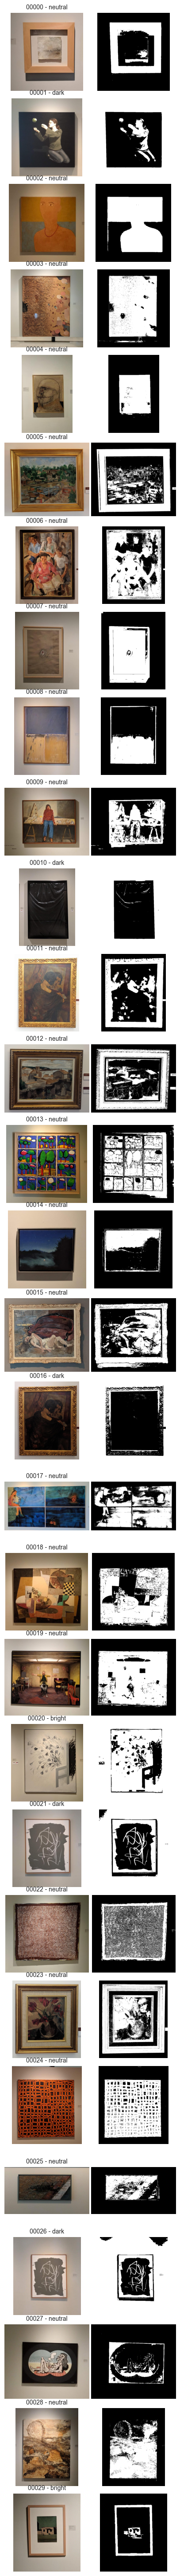

In [15]:
num_images = len(query2_image_PIL_list)
fig, axes = plt.subplots(num_images, 2, figsize=(5, 2.5 * num_images))  # Adjust height based on number of images

for i, (query_image_path, query_image_PIL) in enumerate(zip(sorted(QSD2_W2_PATH.glob("*.jpg")), query2_image_PIL_list)):
    image_classification = classify_image_rgb(query_image_PIL) 

    if image_classification == "dark":
        best_image_channel_mask = apply_otsu_threshold(np.array(query_image_PIL.convert('LAB').split()[0]))  
    elif image_classification == "bright":
        best_image_channel_mask = apply_otsu_threshold(np.array(query_image_PIL.convert('LAB').split()[2]))  
    else:
        best_image_channel_mask = apply_otsu_threshold(np.array(query_image_PIL.convert('HSV').split()[1]))  
    
    # Display original image and mask in the same figure
    axes[i, 0].imshow(np.array(query_image_PIL))  
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(best_image_channel_mask, cmap='gray')  
    axes[i, 1].axis('off')
    
    axes[i, 0].set_title(f"{query_image_path.stem} - {image_classification}", fontsize=10)

plt.subplots_adjust(hspace=.1,wspace=.02)
plt.show()


In [17]:
def get_mask(query_image_PIL, image_classification):
    if image_classification == "neutral":
        _, s, _ = query_image_PIL.convert('HSV').split()  
        th = apply_otsu_threshold(s)  
        w = th.shape[1]  
        
        _, _, stats, _ = cv2.connectedComponentsWithStats(th, connectivity=8)
        stats = stats[1:]  
        largest_label = np.argmax(stats[:, cv2.CC_STAT_AREA])  
        wh = stats[largest_label] 
        width = wh[cv2.CC_STAT_WIDTH]
        pp = width / w  

        if pp < 0.55: # apply dilatation !
            kernel_size = 5
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size)) # Square with dimensions kernel_size x kernel_size
            th = cv2.dilate(th, kernel, iterations=3)
            _, _, stats, _ = cv2.connectedComponentsWithStats(th, connectivity=8)
            stats = stats[1:]
            largest_label = np.argmax(stats[:, cv2.CC_STAT_AREA])
            wh = stats[largest_label]
    
    else: # LAB
        l, _, b = query_image_PIL.convert('LAB').split() 
        if image_classification == "dark": # L
            th = apply_otsu_threshold(l) 
        else: # light, B
            th = apply_otsu_threshold(b) 
        inverted_mask = cv2.bitwise_not(th) 

        _, _, stats, _ = cv2.connectedComponentsWithStats(inverted_mask, connectivity=8)
        stats = stats[1:]  
        largest_label = np.argmax(stats[:, cv2.CC_STAT_AREA])
        wh = stats[largest_label]

    x = wh[cv2.CC_STAT_LEFT]
    y = wh[cv2.CC_STAT_TOP]
    width = wh[cv2.CC_STAT_WIDTH]
    height = wh[cv2.CC_STAT_HEIGHT]
    cleaned_mask = np.zeros_like(th) 
    cleaned_mask[y:y + height, x:x + width] = 255 

    return cleaned_mask  

masks = []
for query_image_PIL in query2_image_PIL_list:
    image_classification = classify_image_rgb(query_image_PIL)  
    mask = get_mask(query_image_PIL, image_classification)  
    masks.append(mask)

## Task 4 & 5 - Background removal evaluation for QSD2-W2
- Precision, recall, F1


In [47]:
query_mask_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD2_W2_PATH.glob("*.png"))]
mask_gt = [np.array(msk) for msk in query_mask_PIL_list] 

def calculate_metrics(pred_mask, true_mask):
    pred_mask_flat = pred_mask.flatten()
    true_mask_flat = true_mask.flatten()

    pred_mask_flat = (pred_mask_flat > 127).astype(int)
    true_mask_flat = (true_mask_flat > 127).astype(int)

    precision = precision_score(true_mask_flat, pred_mask_flat)
    recall = recall_score(true_mask_flat, pred_mask_flat)
    f1 = f1_score(true_mask_flat, pred_mask_flat)

    return precision, recall, f1  

total_precision, total_recall, total_f1 = 0, 0, 0

num_masks = len(masks)  

for pred_mask, true_mask in zip(masks, mask_gt):
    precision, recall, f1 = calculate_metrics(pred_mask, true_mask)  
    total_precision += precision  
    total_recall += recall 
    total_f1 += f1 

avg_precision = total_precision / num_masks
avg_recall = total_recall / num_masks
avg_f1 = total_f1 / num_masks

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")


Average Precision: 0.9393
Average Recall: 0.9656
Average F1 Score: 0.9401


In [48]:
def crop_image_using_mask(image, mask):
    image = np.array(image)
    mask = mask > 0
    
    # Find the coordinates of the non-zero regions in the mask
    y_indices, x_indices = np.where(mask)
    
    # Determine the bounding box
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()
    
    # Crop the image using the bounding box
    cropped_image = image[y_min:y_max + 1, x_min:x_max + 1]
    
    return cropped_image

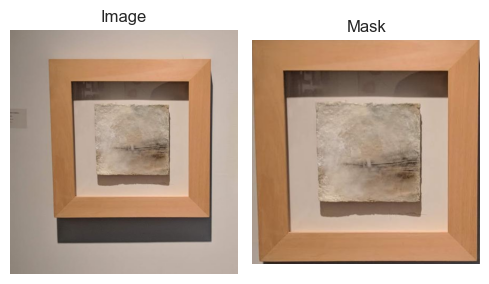

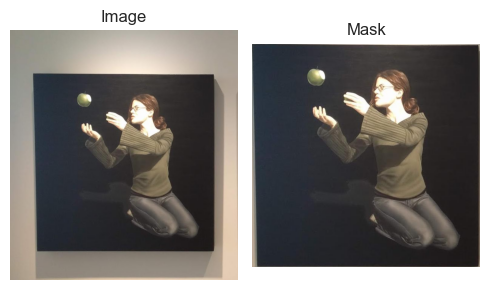

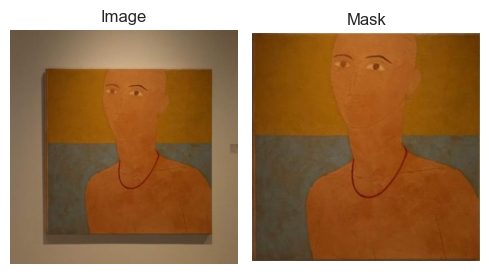

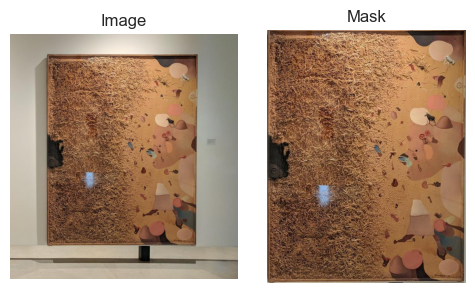

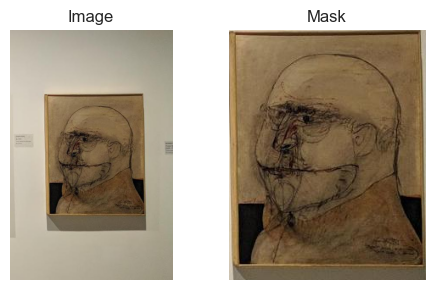

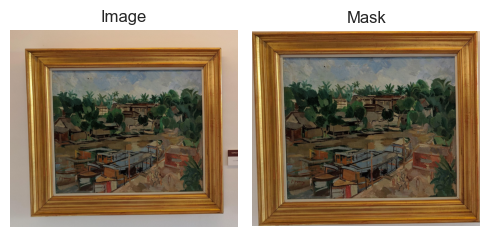

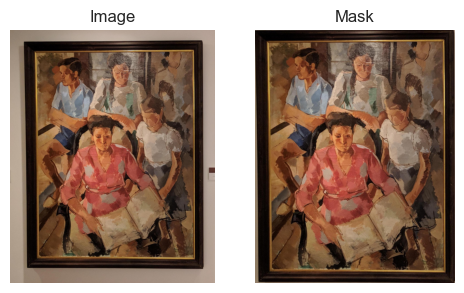

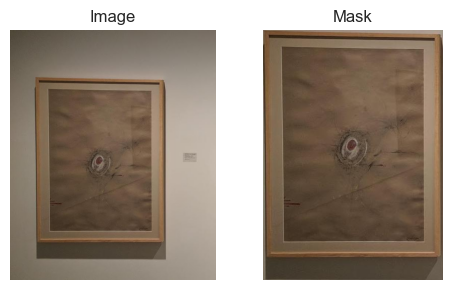

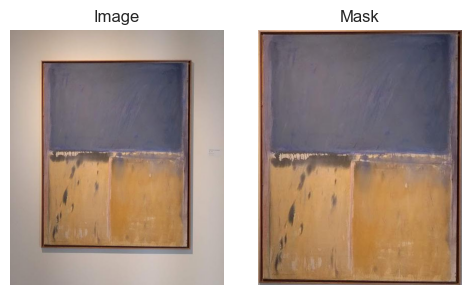

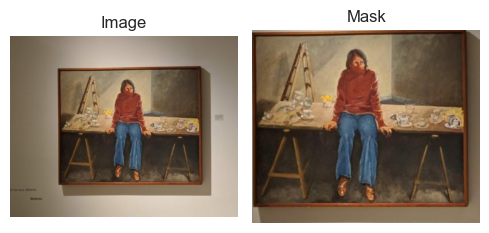

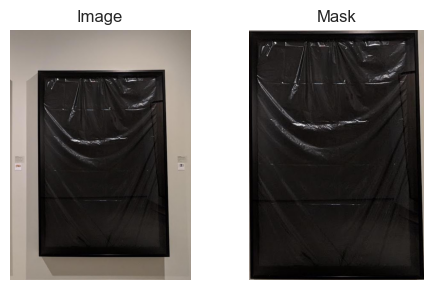

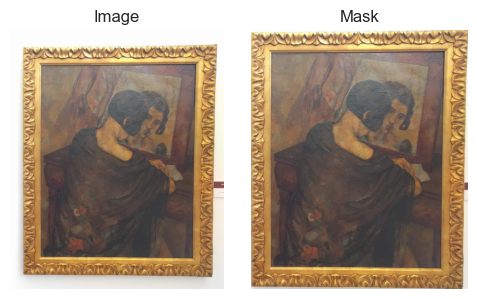

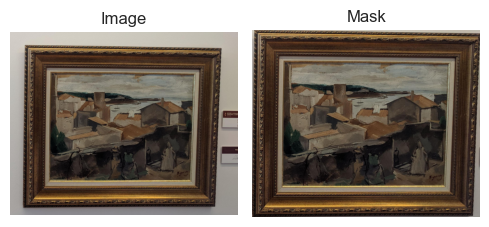

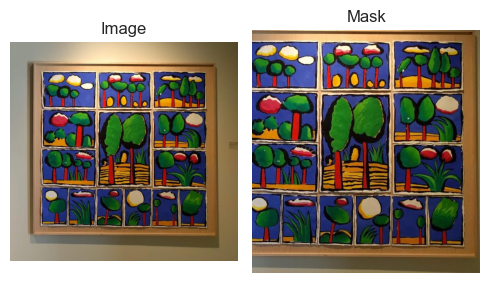

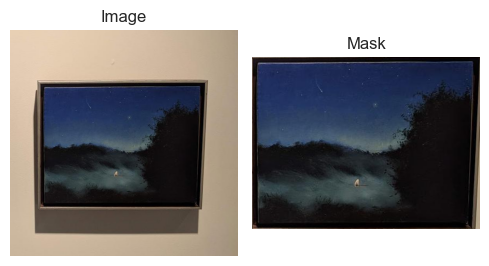

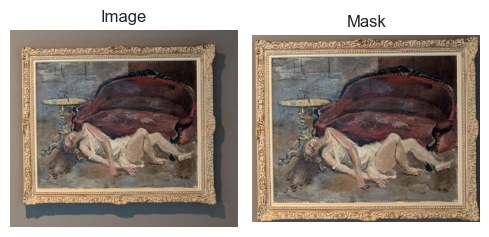

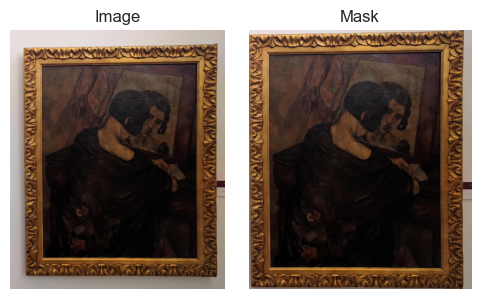

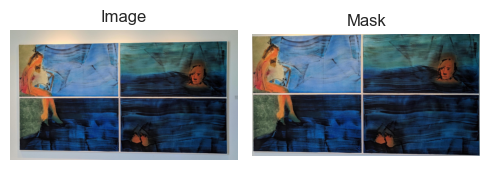

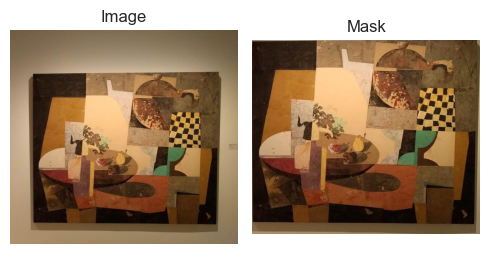

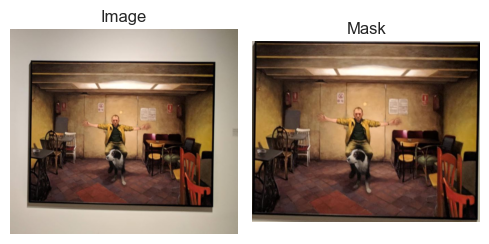

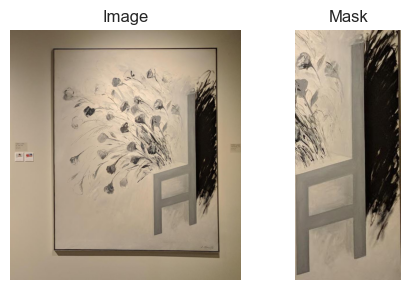

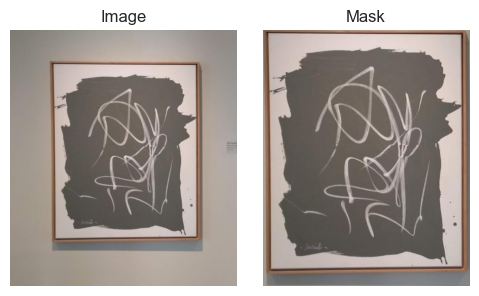

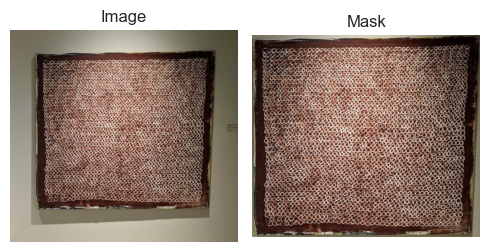

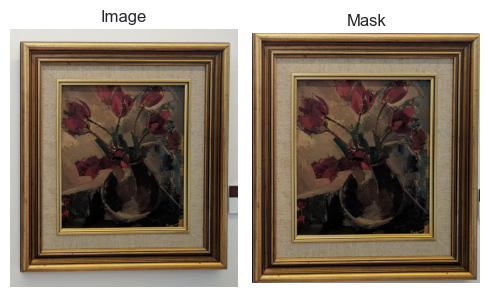

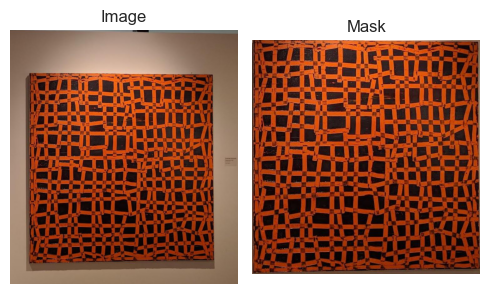

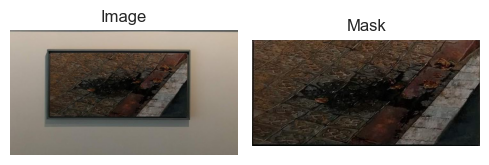

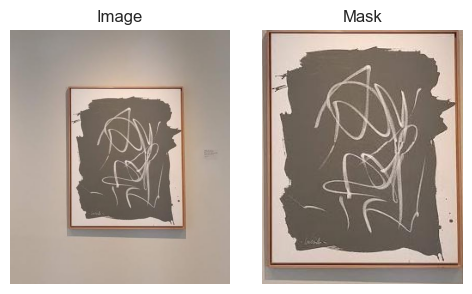

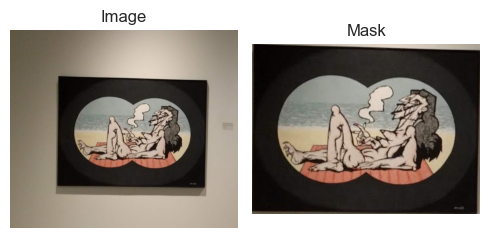

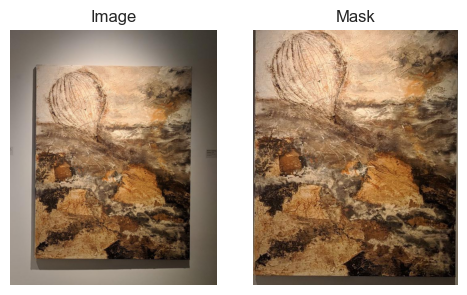

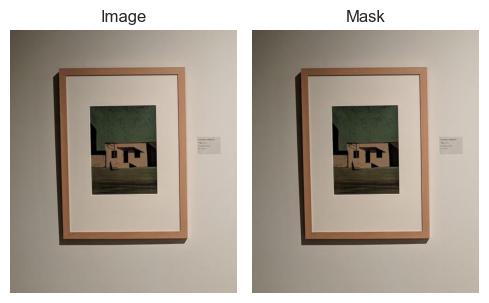

In [49]:
# Loop through the images and their corresponding masks
for idx, (test_image_PIL, mask) in enumerate(zip(query2_image_PIL_list, masks)):
    # Convert the mask to a NumPy array if it's not already one
    mask_array = np.array(mask)

    # Plot the image and mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))

    # Show the image
    axes[0].imshow(test_image_PIL)
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Show the mask as a grayscale image
    axes[1].imshow(mask_array, cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [23]:
partitioned_images_query_D2 = {}

for partition_level in partition_levels:
    partition_level_dir = WEEK_2_RESULTS_PATH / f"partitioned_query_D2_images_level_{partition_level}"

    # If we have previously executed the code, the partitions are stored in the disk and we directly load them
    if partition_level_dir.exists():
        partitioned_images_query_D2[partition_level] = []

        for img_idx in tqdm(range(len(query2_image_PIL_list)), desc=f"Loading images at level {partition_level}"):
            partitions = []
            block_idx = 0
            while True:
                img_path = partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg"
                if not img_path.exists():
                    break
                partitions.append(Image.open(img_path))
                block_idx += 1

            partitioned_images_query_D2[partition_level].append(partitions)

        continue

    # Otherwise we compute and persist the partitions for next executions
    partition_level_dir.mkdir(parents=True, exist_ok=True)

    if partition_level == 1:
        print("Partitioning at level 1")
        partitioned_images_query_D2[partition_level] = [[crop_image_using_mask(img, mask)] for img, mask in zip(query2_image_PIL_list, masks)]
    else:
        partitioned_images_query_D2[partition_level] = [
            partition_image(img, partition_level)
            for img in tqdm(query2_image_PIL_list, desc=f"Partitioning at level {partition_level}")
        ]

    for img_idx, partitions in tqdm(enumerate(partitioned_images_query_D2[partition_level]),
                                    total=len(partitioned_images_query_D2[partition_level]),
                                    desc=f"Saving images at level {partition_level}"):
        for block_idx, block_img in enumerate(partitions):
            block_img.save(partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg")

Loading images at level 5: 100%|██████████| 30/30 [00:00<00:00, 102.33it/s]


In [24]:
partitioned_histograms_query = {}

for descriptor in descriptors:
    print("Descriptor: ", descriptor.name)
    partitioned_histograms_query[descriptor.name] = {}

    for partition_level in partition_levels:
        print("Partition Level: ", partition_level)
        partitioned_histograms_query[descriptor.name][partition_level] = []

        for partitions in tqdm(partitioned_images_query_D2[partition_level]):
            histograms_img = []
            for partition_img in partitions:
                histogram_partition = descriptor.compute(partition_img)
                histograms_img.append(histogram_partition)

            concatenated_histogram = np.concatenate(histograms_img, axis=0)
            partitioned_histograms_query[descriptor.name][partition_level].append(concatenated_histogram)

Descriptor:  MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr
Partition Level:  5


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]


In [25]:
histograms_SPR_DB = {}
histograms_SPR_Q = {}
histograms_BB_DB = {}
histograms_BB_Q = {}

for db_data, query_data in zip(partitioned_histograms_db.items(), partitioned_histograms_query.items()):
    descriptor_db = db_data[0]
    partitions_db = db_data[1]
    descriptor_q = query_data[0]
    partitions_q = query_data[1]
    assert descriptor_db == descriptor_q

    histograms_BB_DB[descriptor_db] = partitioned_histograms_db[descriptor_db]
    histograms_BB_Q[descriptor_db] = partitioned_histograms_query[descriptor_db]

    histograms_SPR_DB[descriptor_db] = []
    for img_idx in range(len(database_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_db[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_DB[descriptor_db].append(concatenated)


    histograms_SPR_Q[descriptor_db] = []
    for img_idx in range(len(query_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_query[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_Q[descriptor_db].append(concatenated)

In [26]:
similarity_classes = [
    HistogramIntersection(),
]

In [27]:
query_descriptor_distances_to_db_list = {}

for similarity in similarity_classes:
    similarity_name = similarity.__class__.__name__
    query_descriptor_distances_to_db_list[similarity_name] = {}
    for descriptor in descriptors:
        descriptor_name = descriptor.name
        print(f"- {similarity_name} & {descriptor_name}")
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name] = {
            "BB": {}, # We will compute one similarity per partition level
            "SPR": [] # We will compute one similarity per image
        }
        query_descriptors = np.array(histograms_SPR_Q[descriptor_name])
        database_descriptors = np.array(histograms_SPR_DB[descriptor_name])

        # COMPUTE SIMILARITIES
        spr_similarity = similarity.compute(query_descriptors, database_descriptors)
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["SPR"] = spr_similarity

        for partition_level in partition_levels:
            partitioned_database_descriptors = np.array(histograms_BB_DB[descriptor_name][partition_level])
            partitioned_query_descriptors = np.array(histograms_BB_Q[descriptor_name][partition_level])
            bb_similarity = similarity.compute(partitioned_query_descriptors, partitioned_database_descriptors)
            query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["BB"][partition_level] = bb_similarity

- HistogramIntersection & MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr


In [28]:
qsd2_distances_to_bbdd = query_descriptor_distances_to_db_list["HistogramIntersection"]["MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr"]["BB"][5]

In [42]:
k = 5
qsd2_retrieved_bbdd_indices, qsd2_retrieved_bbdd_similarity = get_topk_distances(qsd2_distances_to_bbdd, k = k)

In [38]:
for metric in metrics:
    for k in [1, 5]:
        m = round(metric.compute(GT_QSD2_W2_LIST, qsd2_retrieved_bbdd_indices, k), 2)
        print(metric.__class__.__name__, k, m)

MeanAveragePrecisionAtK 1 0.53
MeanAveragePrecisionAtK 5 0.6
MeanAveragePrecisionAtK 20 0.6


## Task 6 - Background removal and retrieval for QST1-W2 and QST2-W2
- Precision, recall, F1


In [ ]:
# QST1

qst1_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QST1_W2_PATH.glob("*.jpg"))]

descriptors = [
    MultiColorSpaceHistogramDescriptor1D(['HSV', 'LAB', 'YCbCr'], histogram_type='log-chromatic')
]
best_similarity = HistogramIntersection()

partition_levels = [5]

In [ ]:
partitioned_images_query_T1 = {}

for partition_level in partition_levels:
    partition_level_dir = WEEK_2_RESULTS_PATH / f"partitioned_query_T1_images_level_{partition_level}"

    # If we have previously executed the code, the partitions are stored in the disk and we directly load them
    if partition_level_dir.exists():
        partitioned_images_query_T1[partition_level] = []

        for img_idx in tqdm(range(len(qst1_image_PIL_list)), desc=f"Loading images at level {partition_level}"):
            partitions = []
            block_idx = 0
            while True:
                img_path = partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg"
                if not img_path.exists():
                    break
                partitions.append(Image.open(img_path))
                block_idx += 1

            partitioned_images_query_T1[partition_level].append(partitions)

        continue

    # Otherwise we compute and persist the partitions for next executions
    partition_level_dir.mkdir(parents=True, exist_ok=True)

    if partition_level == 1:
        print("Partitioning at level 1")
        partitioned_images_query_T1[partition_level] = [[img] for img in qst1_image_PIL_list]
    else:
        partitioned_images_query_T1[partition_level] = [
            partition_image(img, partition_level)
            for img in tqdm(qst1_image_PIL_list, desc=f"Partitioning at level {partition_level}")
        ]

    for img_idx, partitions in tqdm(enumerate(partitioned_images_query_T1[partition_level]),
                                    total=len(partitioned_images_query_T1[partition_level]),
                                    desc=f"Saving images at level {partition_level}"):
        for block_idx, block_img in enumerate(partitions):
            block_img.save(partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg")

In [ ]:
partitioned_histograms_query = {}

for descriptor in descriptors:
    print("Descriptor: ", descriptor.name)
    partitioned_histograms_query[descriptor.name] = {}

    for partition_level in partition_levels:
        print("Partition Level: ", partition_level)
        partitioned_histograms_query[descriptor.name][partition_level] = []

        for partitions in tqdm(partitioned_images_query_T1[partition_level]):
            histograms_img = []
            for partition_img in partitions:
                histogram_partition = descriptor.compute(partition_img)
                histograms_img.append(histogram_partition)

            concatenated_histogram = np.concatenate(histograms_img, axis=0)
            partitioned_histograms_query[descriptor.name][partition_level].append(concatenated_histogram)

In [ ]:
histograms_SPR_DB = {}
histograms_SPR_Q = {}
histograms_BB_DB = {}
histograms_BB_Q = {}

for db_data, query_data in zip(partitioned_histograms_db.items(), partitioned_histograms_query.items()):
    descriptor_db = db_data[0]
    partitions_db = db_data[1]
    descriptor_q = query_data[0]
    partitions_q = query_data[1]
    assert descriptor_db == descriptor_q

    histograms_BB_DB[descriptor_db] = partitioned_histograms_db[descriptor_db]
    histograms_BB_Q[descriptor_db] = partitioned_histograms_query[descriptor_db]

    histograms_SPR_DB[descriptor_db] = []
    for img_idx in range(len(database_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_db[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_DB[descriptor_db].append(concatenated)


    histograms_SPR_Q[descriptor_db] = []
    for img_idx in range(len(query_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_query[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_Q[descriptor_db].append(concatenated)


In [ ]:
similarity_classes = [
    HistogramIntersection(),
]

In [ ]:
query_descriptor_distances_to_db_list = {}

for similarity in similarity_classes:
    similarity_name = similarity.__class__.__name__
    query_descriptor_distances_to_db_list[similarity_name] = {}
    for descriptor in descriptors:
        descriptor_name = descriptor.name
        print(f"- {similarity_name} & {descriptor_name}")
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name] = {
            "BB": {}, # We will compute one similarity per partition level
            "SPR": [] # We will compute one similarity per image
        }
        query_descriptors = np.array(histograms_SPR_Q[descriptor_name])
        database_descriptors = np.array(histograms_SPR_DB[descriptor_name])

        # COMPUTE SIMILARITIES
        spr_similarity = similarity.compute(query_descriptors, database_descriptors)
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["SPR"] = spr_similarity

        for partition_level in partition_levels:
            partitioned_database_descriptors = np.array(histograms_BB_DB[descriptor_name][partition_level])
            partitioned_query_descriptors = np.array(histograms_BB_Q[descriptor_name][partition_level])
            bb_similarity = similarity.compute(partitioned_query_descriptors, partitioned_database_descriptors)
            query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["BB"][partition_level] = bb_similarity

In [ ]:
qst1_distances_to_bbdd = query_descriptor_distances_to_db_list["HistogramIntersection"]["MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr"]["BB"][5]

In [ ]:
k = 10
qst1_retrieved_bbdd_indices, qst1_retrieved_bbdd_similarity = get_topk_distances(qst1_distances_to_bbdd, k = k)

In [ ]:
# QST2

qst2_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QST2_W2_PATH.glob("*.jpg"))]
test_masks = []

for test_image_path, test_image_PIL in zip(sorted(QST2_W2_PATH.glob("*.jpg")), qst2_image_PIL_list):
    image_classification = classify_image_rgb(test_image_PIL)
    mask = get_mask(test_image_PIL, image_classification)
    test_masks.append(mask)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Loop through the images and their corresponding masks
for idx, (test_image_path, test_image_PIL, mask) in enumerate(zip(sorted(QST2_W2_PATH.glob("*.jpg")), qst2_image_PIL_list, test_masks)):
    # Convert the mask to a NumPy array if it's not already one
    mask_array = np.array(mask)

    # Plot the image and mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show the image
    axes[0].imshow(test_image_PIL)
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Show the mask as a grayscale image
    axes[1].imshow(mask_array, cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Convert the mask back to a PIL image for saving
    mask_image = Image.fromarray(mask_array)  # Convert mask to 0-255 range

    # Save the mask as a PNG file
    mask_image.save((WEEK_2_RESULTS_PATH / "masks_qst2" / f"{test_image_path.stem}.png").as_posix())

In [ ]:
def crop_image_using_mask(image, mask):
    image = np.array(image)
    mask = mask > 0
    
    # Find the coordinates of the non-zero regions in the mask
    y_indices, x_indices = np.where(mask)
    
    # Determine the bounding box
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()
    
    # Crop the image using the bounding box
    cropped_image = image[y_min:y_max + 1, x_min:x_max + 1]
    
    return cropped_image

In [ ]:
partitioned_images_query_T2 = {}

for partition_level in partition_levels:
    partition_level_dir = WEEK_2_RESULTS_PATH / f"partitioned_query_T2_images_level_{partition_level}"

    # If we have previously executed the code, the partitions are stored in the disk and we directly load them
    if partition_level_dir.exists():
        partitioned_images_query_T2[partition_level] = []

        for img_idx in tqdm(range(len(qst2_image_PIL_list)), desc=f"Loading images at level {partition_level}"):
            partitions = []
            block_idx = 0
            while True:
                img_path = partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg"
                if not img_path.exists():
                    break
                partitions.append(Image.open(img_path))
                block_idx += 1

            partitioned_images_query_T2[partition_level].append(partitions)

        continue

    # Otherwise we compute and persist the partitions for next executions
    partition_level_dir.mkdir(parents=True, exist_ok=True)

    if partition_level == 1:
        print("Partitioning at level 1")
        partitioned_images_query_T2[partition_level] = [[crop_image_using_mask(img, mask)] for img, mask in zip(qst2_image_PIL_list, test_masks)]
    else:
        partitioned_images_query_T2[partition_level] = [
            partition_image(img, partition_level)
            for img in tqdm(qst2_image_PIL_list, desc=f"Partitioning at level {partition_level}")
        ]

    for img_idx, partitions in tqdm(enumerate(partitioned_images_query_T2[partition_level]),
                                    total=len(partitioned_images_query_T2[partition_level]),
                                    desc=f"Saving images at level {partition_level}"):
        for block_idx, block_img in enumerate(partitions):
            block_img.save(partition_level_dir / f"img_{img_idx}_block_{block_idx}.jpg")

In [ ]:
partitioned_histograms_query = {}

for descriptor in descriptors:
    print("Descriptor: ", descriptor.name)
    partitioned_histograms_query[descriptor.name] = {}

    for partition_level in partition_levels:
        print("Partition Level: ", partition_level)
        partitioned_histograms_query[descriptor.name][partition_level] = []

        for partitions in tqdm(partitioned_images_query_T2[partition_level]):
            histograms_img = []
            for partition_img in partitions:
                histogram_partition = descriptor.compute(partition_img)
                histograms_img.append(histogram_partition)

            concatenated_histogram = np.concatenate(histograms_img, axis=0)
            partitioned_histograms_query[descriptor.name][partition_level].append(concatenated_histogram)

In [ ]:
histograms_SPR_DB = {}
histograms_SPR_Q = {}
histograms_BB_DB = {}
histograms_BB_Q = {}

for db_data, query_data in zip(partitioned_histograms_db.items(), partitioned_histograms_query.items()):
    descriptor_db = db_data[0]
    partitions_db = db_data[1]
    descriptor_q = query_data[0]
    partitions_q = query_data[1]
    assert descriptor_db == descriptor_q

    histograms_BB_DB[descriptor_db] = partitioned_histograms_db[descriptor_db]
    histograms_BB_Q[descriptor_db] = partitioned_histograms_query[descriptor_db]

    histograms_SPR_DB[descriptor_db] = []
    for img_idx in range(len(database_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_db[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_DB[descriptor_db].append(concatenated)


    histograms_SPR_Q[descriptor_db] = []
    for img_idx in range(len(query_image_PIL_list)):
        image_histograms = []
        for partition_level in partition_levels:
            image_histograms.append(partitioned_histograms_query[descriptor_db][partition_level][img_idx])

        concatenated = np.concatenate(image_histograms, axis=0)
        histograms_SPR_Q[descriptor_db].append(concatenated)

In [ ]:
similarity_classes = [
    HistogramIntersection(),
]

In [ ]:
query_descriptor_distances_to_db_list = {}

for similarity in similarity_classes:
    similarity_name = similarity.__class__.__name__
    query_descriptor_distances_to_db_list[similarity_name] = {}
    for descriptor in descriptors:
        descriptor_name = descriptor.name
        print(f"- {similarity_name} & {descriptor_name}")
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name] = {
            "BB": {}, # We will compute one similarity per partition level
            "SPR": [] # We will compute one similarity per image
        }
        query_descriptors = np.array(histograms_SPR_Q[descriptor_name])
        database_descriptors = np.array(histograms_SPR_DB[descriptor_name])

        # COMPUTE SIMILARITIES
        spr_similarity = similarity.compute(query_descriptors, database_descriptors)
        query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["SPR"] = spr_similarity

        for partition_level in partition_levels:
            partitioned_database_descriptors = np.array(histograms_BB_DB[descriptor_name][partition_level])
            partitioned_query_descriptors = np.array(histograms_BB_Q[descriptor_name][partition_level])
            bb_similarity = similarity.compute(partitioned_query_descriptors, partitioned_database_descriptors)
            query_descriptor_distances_to_db_list[similarity_name][descriptor_name]["BB"][partition_level] = bb_similarity

In [ ]:
qst2_distances_to_bbdd = query_descriptor_distances_to_db_list["HistogramIntersection"]["MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr"]["BB"][5]

In [ ]:
k = 10
qst2_retrieved_bbdd_indices, qst2_retrieved_bbdd_similarity = get_topk_distances(qst2_distances_to_bbdd, k = k)

In [ ]:
import pickle

# Exporting the results to the corresponding output files
with open(WEEK_2_RESULTS_PATH / "qst1_result.pkl", 'wb') as f:
    pickle.dump(qst1_retrieved_bbdd_indices, f)

with open(WEEK_2_RESULTS_PATH / "qst2_result.pkl", 'wb') as f:
    pickle.dump(qst2_retrieved_bbdd_indices, f)